In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, Dropout

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
img_array_all = np.load('/content/drive/My Drive/Colab Notebooks/PostDoc/img_array_all1.npy').astype('float32')
print(img_array_all.shape)

(3236, 224, 224, 6)


In [3]:
img_array_all2 = np.load('/content/drive/My Drive/Colab Notebooks/PostDoc/img_array_all2.npy').astype('float32')
print(img_array_all2.shape)

(1090, 224, 224, 6)


In [4]:
img_array_all = np.concatenate((img_array_all, img_array_all2), axis=0);
print(img_array_all.shape)

(4326, 224, 224, 6)


In [5]:
del img_array_all2

# array to tfrecoed

In [ ]:
import tensorflow as tf

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((img_array_all[:1000,:,:,:5], img_array_all[:1000,:,:,5]))

In [ ]:
del img_array_all

In [ ]:
train_dataset2 = train_dataset

In [ ]:
print('train_dataset',train_dataset.zip(train_dataset2))

train_dataset <ZipDataset shapes: ((224, 224, 5), (224, 224)), types: (tf.float32, tf.float32)>


In [ ]:
RepeatDataset = type(tf.data.Dataset().repeat())
try:
  while not isinstance(train_dataset, RepeatDataset):
    train_dataset = train_dataset._input_dataset
except AttributeError:
  warnings.warn('no epoch counter found')
  epoch_counter = None
else:
  epoch_counter = train_dataset._count

TypeError: ignored

# train and test dataset

In [3]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(img_array_all, test_size=0.2, random_state=42)
print(len(train_set))
print(len(test_set))

2588
648


In [4]:
del img_array_all

In [5]:
x_train = train_set[:,:,:,:5]
#img_array_all = np.full((train_set.shape[0],train_set.shape[1],train_set.shape[2],1), 0)
y_train = train_set[:,:,:,5].reshape(train_set.shape[0],train_set.shape[1],train_set.shape[2],1).astype('float32')
x_test = test_set[:,:,:,:5]
y_test = test_set[:,:,:,5].reshape(test_set.shape[0],test_set.shape[1],test_set.shape[2],1).astype('float32')



In [6]:
del train_set
del test_set


In [7]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(2588, 224, 224, 5)
(2588, 224, 224, 1)
(648, 224, 224, 5)
(648, 224, 224, 1)


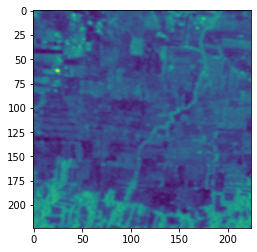

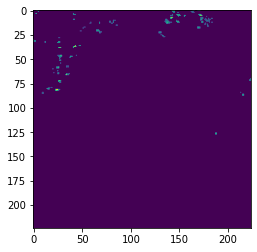

In [8]:
plt.imshow(x_train[24,:,:,1].astype('float32'))
plt.show()

plt.imshow(y_train[24,:,:,0].astype('float32'))
plt.show()

In [9]:
x_in = Input(shape=(224, 224, 5))

'''Encoder'''
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_in)
x_temp = Dropout(0.25)(x_temp)
x_skip1 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip1)
x_temp = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip2 = Conv2D(32, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip2)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.25)(x_temp)
x_skip3 = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = MaxPooling2D((2,2))(x_skip3)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2D(64, (3, 3), activation='relu', padding='same')(x_temp)

'''Decoder'''
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip3])
x_temp = Conv2DTranspose(64, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(64, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip2])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu',  padding='same')(x_temp)
x_temp = Concatenate()([x_temp, x_skip1])
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)
x_temp = Dropout(0.5)(x_temp)
x_temp = Conv2DTranspose(32, (3, 3), activation='relu',  padding='same')(x_temp)

'''Use 1 by 1 Convolution to get desired output bands'''
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)
x_temp = Conv2D(32, (1, 1), activation='relu', padding='same')(x_temp)

# output layer has linear activation function for regression
x_out = Conv2D(1, (1, 1), activation='linear', padding='same')(x_temp)   

model = Model(inputs=x_in, outputs=x_out)

model.compile(loss='mean_squared_error', optimizer='adam')

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 5) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 32) 1472        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 224, 224, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 224, 224, 32) 9248        dropout[0][0]                    
______________________________________________________________________________________________

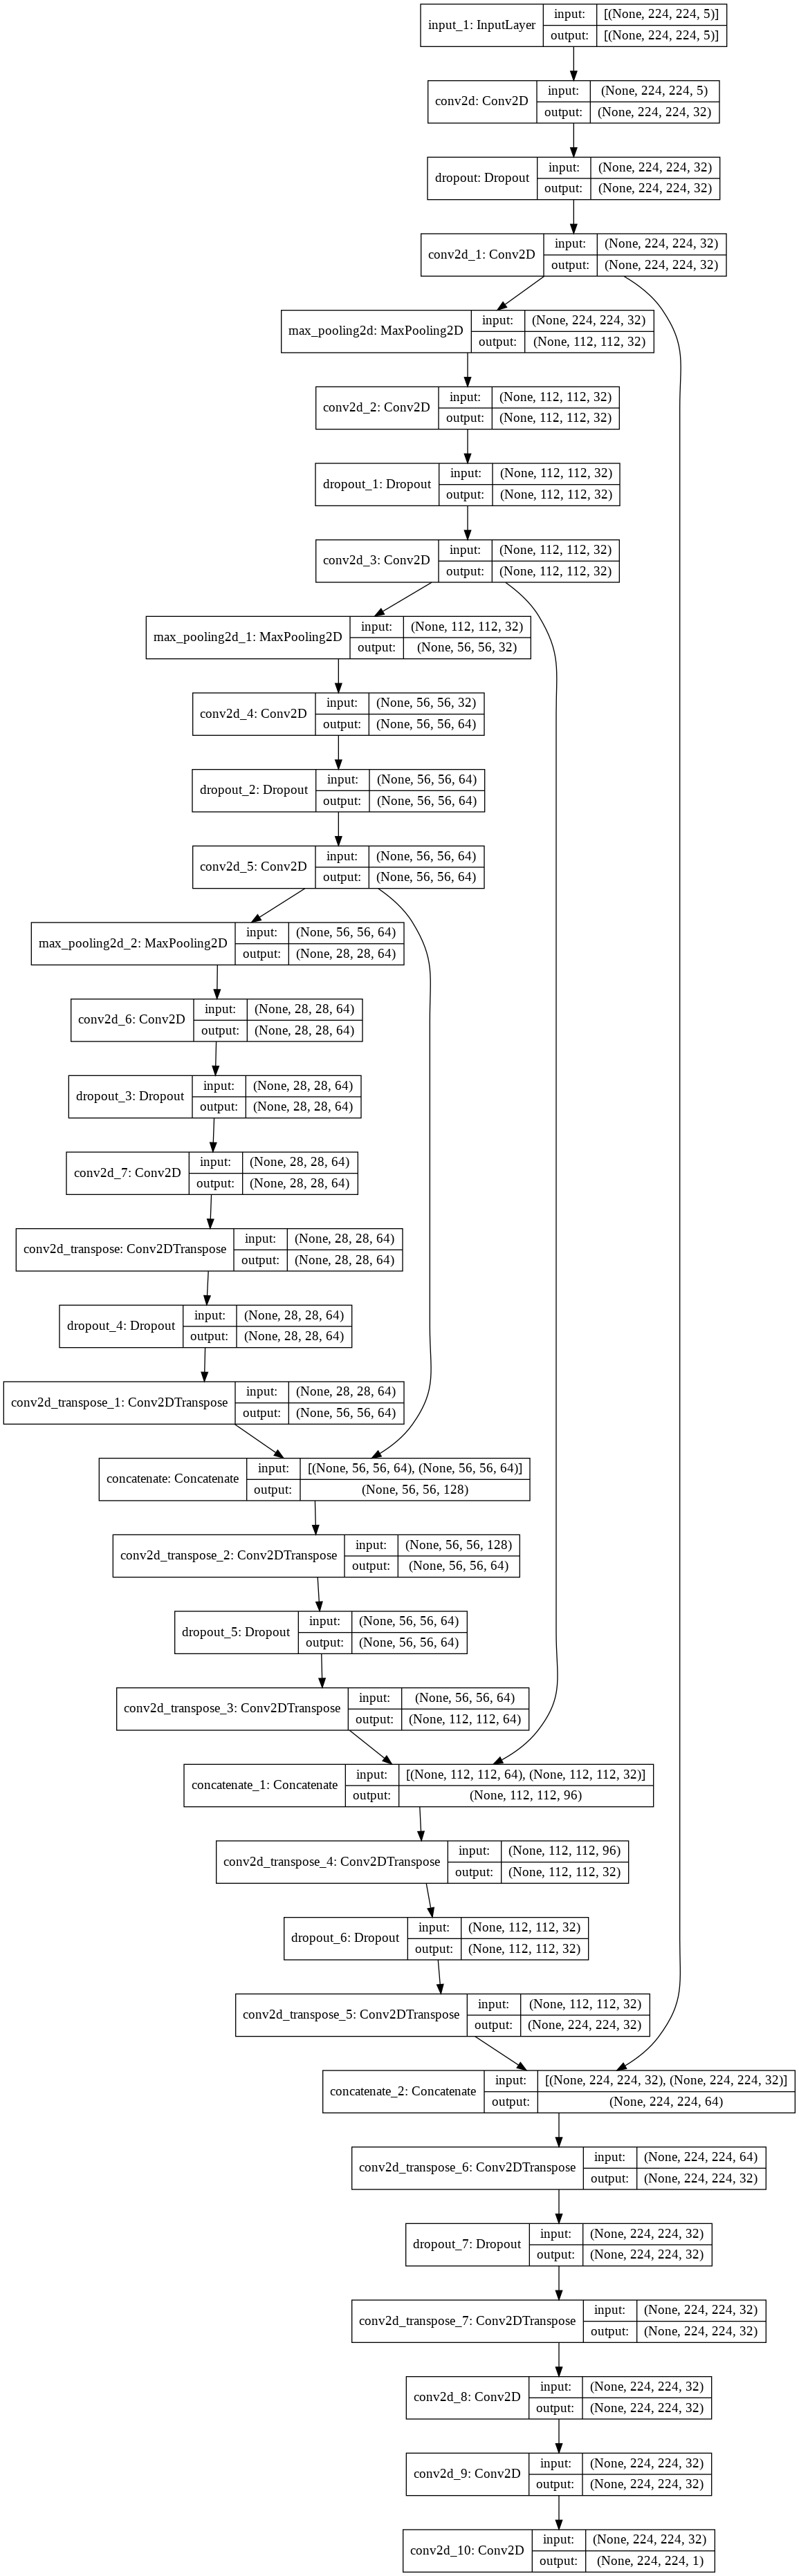

In [10]:
from tensorflow.keras.utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [11]:
import keras
model_file = '/content/drive/My Drive/Colab Notebooks/PostDoc/PostDoc_Model01.h5'

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 10 == 0: print('')
        print('.', end='')

callback_list = [checkpoint, PrintDot()]

In [12]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=250, batch_size=10, verbose=1, callbacks = callback_list)

Epoch 1/250
259/259 [==============================] - 115s 315ms/step - loss: 20.5091 - val_loss: 17.1939

.Epoch 2/250
259/259 [==============================] - 77s 299ms/step - loss: 17.9377 - val_loss: 15.3418
.Epoch 3/250
259/259 [==============================] - 77s 299ms/step - loss: 16.6896 - val_loss: 15.2212
.Epoch 4/250
259/259 [==============================] - 77s 299ms/step - loss: 16.6474 - val_loss: 14.7314
.Epoch 5/250
259/259 [==============================] - 78s 299ms/step - loss: 16.0256 - val_loss: 15.0656
.Epoch 6/250
259/259 [==============================] - 78s 300ms/step - loss: 15.8906 - val_loss: 14.0776
.Epoch 7/250
259/259 [==============================] - 78s 300ms/step - loss: 16.0624 - val_loss: 14.8700
.Epoch 8/250
259/259 [==============================] - 77s 299ms/step - loss: 15.7615 - val_loss: 14.1496
.Epoch 9/250
259/259 [==============================] - 77s 299ms/step - loss: 15.5094 - val_loss: 14.1584
.Epoch 10/250
259/259 [=============

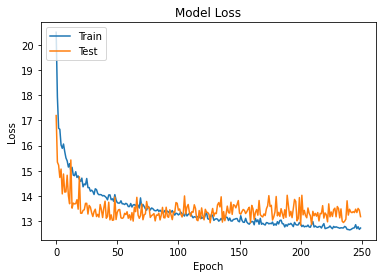

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

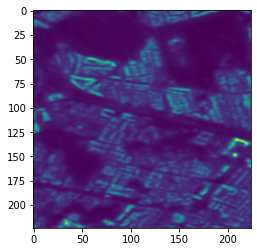

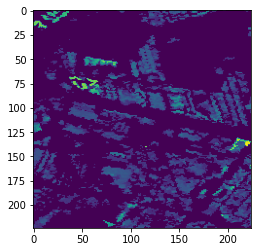

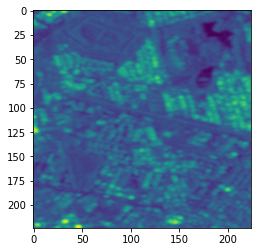

In [14]:
'''Prediction over the test dataset'''
pred_test = model.predict(x_test)

#pred_test = np.argmax(pred_test, axis=-1)
#print(pred_test.shape)

#let's compare sample predicted and actual land cover image with input RGB image

plt.imshow(pred_test[190, :, :,0].astype('float32'))
plt.show()
plt.imshow(y_test[190, :, :, 0].astype('float32'))
plt.show()
plt.imshow(x_test[190,:,:,0].astype('float32'))
plt.show()

In [ ]:
weights = model.layers[0].get_weights()[0]  # layer[-1] input # get_weights() [0]weights [1]biases
print(weights)

IndexError: ignored